In [1]:
import xarray as xr
import xroms
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import cmocean.cm as cmo

### Best to run on Katana on demand, 24 cores

In [2]:
# from distributed import Client, progress, LocalCluster
# import socket

# client = Client(service_kwargs={'dashboard': {'prefix': f'/node/{socket.gethostname()}/8787'}})

### use glob to get list of filenames for EAC-ROMS v3

In [2]:
# chunks = {'ocean_time':10}
# filelist=[]
# for files in glob('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_0[0-9]*.nc'): 
#     filelist.append(files)

### load in the data (should take about 35 secs)

In [4]:
#ds = xroms.open_mfnetcdf(filelist, chunks=chunks)

### Or, use local example file

In [3]:
ds = xroms.open_netcdf('../ROMS/outer_avg_01461.nc')

### Calculate means and load into memory - not necessary, but makes plotting quicker later on (should take about 1min 40 secs)
#### Could also save these as .nc files for repeated use
Note that we interpolate U and V onto the rho grid for plotting purposes

In [4]:
SSH_mean = ds.zeta.mean('ocean_time').load()
SST_mean = ds.temp.isel(s_rho=-1).mean('ocean_time').load()
Usurf_mean = ds.u.isel(s_rho=-1).mean('ocean_time').xroms.to_grid('rho').load()
Vsurf_mean = ds.v.isel(s_rho=-1).mean('ocean_time').xroms.to_grid('rho').load()

/Users/neilmalan/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/neilmalan/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/neilmalan/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/neilmalan/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [5]:
def magnitude(a, b):
    func = lambda x, y: np.sqrt(x ** 2 + y ** 2)
    return xr.apply_ufunc(func, a, b, dask="parallelized")

In [6]:
ds['Speed_mean'] = magnitude(Usurf_mean, Vsurf_mean)

## Make some plots
To plot U and V as vector arrows, we need to interpolate them onto the same grid (in this case the rho grid), we can also normalise them so that they only show direction, as this makes the plot neater, and the underlying pcolor gives their magnitude anyway

In [7]:
# normalise arrows to only show direction
U = (Usurf_mean/ds.Speed_mean)
V = (Vsurf_mean/ds.Speed_mean)

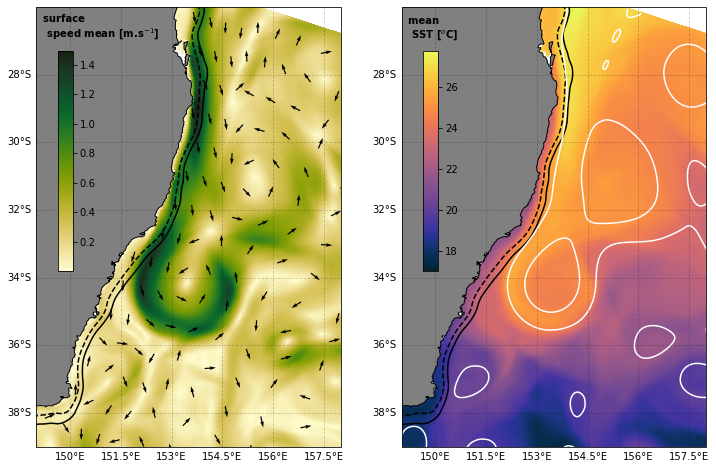

In [8]:
fig = plt.figure(figsize=(12,10))
#set coastline
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

#plot only every 20th arrow
skip = (slice(None, None, 20), slice(None, None, 20))

#plot
ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im=ds.Speed_mean.plot.pcolormesh('lon_rho', 'lat_rho',cmap=cmo.speed, ax=ax,add_colorbar=False)
ds.h.plot.contour('lon_rho', 'lat_rho', ax=ax, colors='black', levels=[200,1000],linestyles=('dashed','solid'))
Q = plt.quiver(ds.lon_rho[skip], ds.lat_rho[skip], U[skip], V[skip], units='width')
ax.set_extent([149,158,-26,-39])
#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
#label to tell what it is
plt.text(149.2,-26.9,'surface \n speed mean [m.s$^{-1}$]',weight='bold')

# colorbar
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.4, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)

ax = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im=SST_mean.plot.pcolormesh('lon_rho', 'lat_rho',cmap=cmo.thermal, ax=ax,add_colorbar=False)
ds.h.plot.contour('lon_rho', 'lat_rho', ax=ax, colors='black', levels=[200,1000],linestyles=('dashed','solid'))
SSH_mean.plot.contour('lon_rho', 'lat_rho', ax=ax, colors='white')
ax.set_extent([149,158,-26,-39])
#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
#label to tell what it is
plt.text(149.2,-26.9,'mean \n SST [$^{o}$C]',weight='bold')

# colorbar
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.4, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)